In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
# Visualization libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string
# Sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
#Cleaning and Preprocessing before topics
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
#building the model
from gensim import corpora
import smart_open
import pickle 
import gensim
#Visualizing topics
import pyLDAvis
import pyLDAvis.gensim_models
#recomendations
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
filename = r'Notas Econews - Hoja 1.csv'
notas = pd.read_csv(filename)

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*notas.shape))

# ... and duplicates
print("It contains {} duplicates.".format(notas.duplicated().sum()))

The dataset has 155 rows and 9 columns.
It contains 0 duplicates.


c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
notas.head()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha publicación,Section,referral,direct,Paid,organic,Unique viewed pages,Page,Text
0,10/06/2021,Research,461,118.0,28,26.0,633,¿Está limpia el agua de tu playa favorita?,"El 88,5% de las aguas de baño del país, fueron..."
1,11/10/2021,Research,366,67.0,87,3.0,523,¿Existe relación entre contaminación y salud m...,Diversos estudios han encontrado una relación ...
2,19/12/2019,Research,84,46.0,6,21.0,157,Bajar el CO2: el desafío climático,El cambio climático es el mayor desafío de los...
3,1/12/2020,Research,87,21.0,3,23.0,134,Conflicto regional por la gestión de los recur...,Variadas proyecciones se han esbozado en los ú...
4,15/01/2020,Research,47,33.0,0,6.0,86,COP25: la incapacidad política delega responsa...,"Como nunca antes, el mundo es consciente de la..."


### Visualizing the Data with WordClouds

In [4]:
def plot_wordcloud(string, language, title):
    
    # Generate WordCloud
    wordcloud = WordCloud(max_words=200, background_color="black", 
                      width=3000, height=2000,
                      stopwords=stopwords.words(language)).generate(string)

    # Plotting
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize=18, fontweight='bold')
    plt.show()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


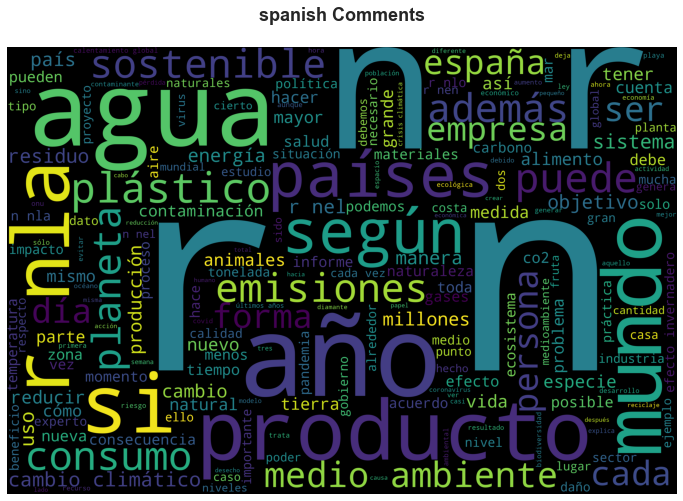

In [5]:
english_comments = str(notas["Text"].values).lower()
plot_wordcloud(english_comments, 'spanish', 'spanish Comments\n')

### Notes lengh

In [6]:
notas['text_length'] = notas["Text"].apply(len)
notas.head()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha publicación,Section,referral,direct,Paid,organic,Unique viewed pages,Page,Text,text_length
0,10/06/2021,Research,461,118.0,28,26.0,633,¿Está limpia el agua de tu playa favorita?,"El 88,5% de las aguas de baño del país, fueron...",2332
1,11/10/2021,Research,366,67.0,87,3.0,523,¿Existe relación entre contaminación y salud m...,Diversos estudios han encontrado una relación ...,2929
2,19/12/2019,Research,84,46.0,6,21.0,157,Bajar el CO2: el desafío climático,El cambio climático es el mayor desafío de los...,4368
3,1/12/2020,Research,87,21.0,3,23.0,134,Conflicto regional por la gestión de los recur...,Variadas proyecciones se han esbozado en los ú...,8513
4,15/01/2020,Research,47,33.0,0,6.0,86,COP25: la incapacidad política delega responsa...,"Como nunca antes, el mundo es consciente de la...",4231


### Topic Modeling

####  Cleaning and Preprocessing

In [7]:
stopwords = nltk.corpus.stopwords.words('spanish')
#agrego estas palabras a la lista de stopwords
stopwords.append("a")
stopwords.append("según")
stopwords.append("si")
stopwords.append("ser")
stopwords.append("cada")
stopwords.append("puede")
stopwords.append("vez")
stopwords.append("además")
stopwords.append("tener")
stopwords.append("así")
stopwords.append("manera")
stopwords.append("medio")
stopwords.append("año")
stopwords.append("años")
stopwords.append("países")
stopwords.append("país")
stopwords.append("cómo")
stopwords.append("persona")
stopwords.append("españa")
stopwords.append("uso")
stopwords.append("natural")
stopwords.append("zona")
stopwords.append("planeta")
len(stopwords)
type(stopwords)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [8]:
#exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The lemmatized form of leaves is: leaf


In [10]:
# We tokenize the sentence, remove punctuation,
# remove stopwords.
# Finally, we convert it back to a string.

def clean_text(text):
    tokens = word_tokenize(text)
    lowercased = [token.lower() for token in tokens]
    no_punct = [token for token in lowercased if token.isalpha()]
    #stopwords = set(stopwords.words('spanish'))
    no_stopwords = [word for word in no_punct if word not in stopwords]

           #esto quiere decir funcion()for word in list
           #lo hacemos xq sino lema no puede con una lista directamente, sino palabras sueltas 
            #es decir  no podemos
    lemma_tokens = [lemma.lemmatize(token) for token in no_stopwords]
    return (lemma_tokens)   

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#pruebo si funciona para una oracion primero
text1 ="El pasado 14 de agosto se registró lluvia en Groenlandia, según reportaron desde el Centro de Datos de Nieve y Hielo de Estados Unidos (NSIDC); región dónde no llovía hace más de 70 años"

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
clean_text(text1)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['pasado',
 'agosto',
 'registró',
 'lluvia',
 'groenlandia',
 'reportaron',
 'centro',
 'datos',
 'nieve',
 'hielo',
 'unidos',
 'nsidc',
 'región',
 'dónde',
 'llovía',
 'hace']

In [13]:
# using function ins nlp_functions.py from _functions_ folder
notas['text'] = notas["Text"].apply(lambda x: clean_text(x))
notas['text']

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [agua, baño, calificadas, excelente, datos, in...
1      [diversos, estudios, encontrado, relación, alt...
2      [cambio, climático, mayor, desafío, tiempos, a...
3      [variadas, proyecciones, esbozado, últimos, me...
4      [nunca, mundo, consciente, imperiosa, necesida...
                             ...                        
150    [finalizó, cumbre, clima, madrid, promesas, ha...
151    [últimamente, encontramos, toda, partes, palab...
152    [gobierno, español, aceptó, cambio, sede, sant...
153    [superficie, cubierta, océanos, contienen, agu...
154    [seres, humanos, cometiendo, atrocidades, natu...
Name: text, Length: 155, dtype: object

In [14]:
#notas['text_cleaned'] = [i.split() for i in notas['text']]

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####  Building the model
<a id='5.2 Building the model'></a>
First, we create a Gensim dictionary from the normalized data, then we convert this to a bag-of-words corpus, and save both dictionary and corpus for future use.

In [15]:
# Creating the term dictionary of our corpus, 
# where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(notas['text'])
corpus = [dictionary.doc2bow(text) for text in notas['text']]
print(dictionary)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary(9147 unique tokens: ['acerca', 'acostamos', 'actividad', 'actividades', 'acuerdo']...)


In [16]:
# Alphabetical order for each of the sentences that you have
#print(dictionary.token2id) 

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#and save it for future use
#uncoment si es la primera ver que lo usas en una compu
# Uncomment the code if working locally

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


let find 3 topics

In [18]:
# uncomment the code if working locally
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
ldamodel.save('lda_3_topics.gensim')

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
ldamodel3 = gensim.models.ldamodel.LdaModel.load('lda_3_topics.gensim')
topics3 = ldamodel3.print_topics(num_words=10)
for topic in topics3:
    print(topic)

(0, '0.005*"agua" + 0.003*"mundo" + 0.002*"sostenible" + 0.002*"millones" + 0.002*"especies" + 0.002*"residuos" + 0.002*"energía" + 0.002*"persona" + 0.002*"sistema" + 0.002*"cambio"')
(1, '0.005*"cambio" + 0.004*"climático" + 0.004*"emisiones" + 0.003*"agua" + 0.003*"global" + 0.003*"mundo" + 0.003*"forma" + 0.003*"gas" + 0.003*"sostenible" + 0.003*"crisis"')
(2, '0.004*"productos" + 0.003*"consumo" + 0.003*"ambiente" + 0.003*"vida" + 0.003*"residuos" + 0.002*"tierra" + 0.002*"agua" + 0.002*"cambio" + 0.002*"alimentos" + 0.002*"producción"')


c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


let find 5 topics

In [22]:
# uncomment the code if working locally
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
ldamodel.save('lda_5_topics.gensim')

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
ldamodel5 = gensim.models.ldamodel.LdaModel.load('lda_5_topics.gensim')
topics5 = ldamodel5.print_topics(num_words=10)
for topic in topics5:
    print(topic)

(0, '0.004*"residuos" + 0.003*"plástico" + 0.003*"mundo" + 0.003*"ambiente" + 0.003*"sostenible" + 0.003*"producción" + 0.003*"persona" + 0.003*"productos" + 0.003*"forma" + 0.002*"parte"')
(1, '0.004*"agua" + 0.004*"cambio" + 0.003*"energía" + 0.003*"mar" + 0.003*"sostenible" + 0.003*"gas" + 0.003*"especies" + 0.003*"climático" + 0.003*"diamante" + 0.002*"contaminación"')
(2, '0.004*"productos" + 0.003*"climático" + 0.003*"tierra" + 0.003*"cambio" + 0.003*"crisis" + 0.003*"global" + 0.003*"incendios" + 0.003*"calentamiento" + 0.002*"animales" + 0.002*"salud"')
(3, '0.005*"agua" + 0.004*"mundo" + 0.004*"vida" + 0.004*"tierra" + 0.004*"ambiente" + 0.004*"día" + 0.004*"biodiversidad" + 0.003*"climático" + 0.003*"cambio" + 0.003*"millones"')
(4, '0.005*"cambio" + 0.005*"agua" + 0.004*"consumo" + 0.004*"emisiones" + 0.003*"animales" + 0.003*"mundo" + 0.003*"contaminación" + 0.003*"productos" + 0.003*"climático" + 0.002*"producción"')


c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### *Visualizing topics*

The pyLDAvis library is designed to provide a visual interface for interpreting the topics derived from a topic model by extracting information from a fitted LDA topic model.

***The following code should be run locally only!***

In [24]:
import pyLDAvis.gensim_models

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# visualizing 3 topics
lda_display3 = pyLDAvis.gensim_models.prepare(ldamodel3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# visualizing 5 topics
lda_display5 = pyLDAvis.gensim_models.prepare(ldamodel5, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display5)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**6. What is the Dominant topic and its percentage contribution in each document**

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [28]:
notas.rename(columns={'Text': 'Text original'}, inplace=True)
notas.head()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha publicación,Section,referral,direct,Paid,organic,Unique viewed pages,Page,Text original,text_length,text
0,10/06/2021,Research,461,118.0,28,26.0,633,¿Está limpia el agua de tu playa favorita?,"El 88,5% de las aguas de baño del país, fueron...",2332,"[agua, baño, calificadas, excelente, datos, in..."
1,11/10/2021,Research,366,67.0,87,3.0,523,¿Existe relación entre contaminación y salud m...,Diversos estudios han encontrado una relación ...,2929,"[diversos, estudios, encontrado, relación, alt..."
2,19/12/2019,Research,84,46.0,6,21.0,157,Bajar el CO2: el desafío climático,El cambio climático es el mayor desafío de los...,4368,"[cambio, climático, mayor, desafío, tiempos, a..."
3,1/12/2020,Research,87,21.0,3,23.0,134,Conflicto regional por la gestión de los recur...,Variadas proyecciones se han esbozado en los ú...,8513,"[variadas, proyecciones, esbozado, últimos, me..."
4,15/01/2020,Research,47,33.0,0,6.0,86,COP25: la incapacidad política delega responsa...,"Como nunca antes, el mundo es consciente de la...",4231,"[nunca, mundo, consciente, imperiosa, necesida..."


In [29]:
data = notas["Text original"].values.tolist()

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
#This way, you will know which document belongs predominantly to which topic.
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel4, corpus=corpus, texts=notas['text'])

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df_topic_sents_keywords

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,3.0,0.9958,"emisiones, agua, mar, sostenible, consumo, mun...","[agua, baño, calificadas, excelente, datos, in..."
1,0.0,0.9965,"residuos, agua, cambio, animales, climático, a...","[diversos, estudios, encontrado, relación, alt..."
2,3.0,0.9943,"emisiones, agua, mar, sostenible, consumo, mun...","[cambio, climático, mayor, desafío, tiempos, a..."
3,1.0,0.9989,"agua, mundo, plástico, cambio, alimentos, part...","[variadas, proyecciones, esbozado, últimos, me..."
4,1.0,0.9976,"agua, mundo, plástico, cambio, alimentos, part...","[nunca, mundo, consciente, imperiosa, necesida..."
...,...,...,...,...
150,3.0,0.9968,"emisiones, agua, mar, sostenible, consumo, mun...","[finalizó, cumbre, clima, madrid, promesas, ha..."
151,0.0,0.9970,"residuos, agua, cambio, animales, climático, a...","[últimamente, encontramos, toda, partes, palab..."
152,1.0,0.9955,"agua, mundo, plástico, cambio, alimentos, part...","[gobierno, español, aceptó, cambio, sede, sant..."
153,1.0,0.9973,"agua, mundo, plástico, cambio, alimentos, part...","[superficie, cubierta, océanos, contienen, agu..."


In [33]:
notas.drop(['text'], axis=1, inplace=True)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
unido = pd.concat([notas, df_topic_sents_keywords], axis=1)
unido.head(5)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha publicación,Section,referral,direct,Paid,organic,Unique viewed pages,Page,Text original,text_length,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,10/06/2021,Research,461,118.0,28,26.0,633,¿Está limpia el agua de tu playa favorita?,"El 88,5% de las aguas de baño del país, fueron...",2332,3.0,0.9958,"emisiones, agua, mar, sostenible, consumo, mun...","[agua, baño, calificadas, excelente, datos, in..."
1,11/10/2021,Research,366,67.0,87,3.0,523,¿Existe relación entre contaminación y salud m...,Diversos estudios han encontrado una relación ...,2929,0.0,0.9965,"residuos, agua, cambio, animales, climático, a...","[diversos, estudios, encontrado, relación, alt..."
2,19/12/2019,Research,84,46.0,6,21.0,157,Bajar el CO2: el desafío climático,El cambio climático es el mayor desafío de los...,4368,3.0,0.9943,"emisiones, agua, mar, sostenible, consumo, mun...","[cambio, climático, mayor, desafío, tiempos, a..."
3,1/12/2020,Research,87,21.0,3,23.0,134,Conflicto regional por la gestión de los recur...,Variadas proyecciones se han esbozado en los ú...,8513,1.0,0.9989,"agua, mundo, plástico, cambio, alimentos, part...","[variadas, proyecciones, esbozado, últimos, me..."
4,15/01/2020,Research,47,33.0,0,6.0,86,COP25: la incapacidad política delega responsa...,"Como nunca antes, el mundo es consciente de la...",4231,1.0,0.9976,"agua, mundo, plástico, cambio, alimentos, part...","[nunca, mundo, consciente, imperiosa, necesida..."


In [35]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text original']
df_dominant_topic.head(10)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text original
0,0,3.0,0.9958,"emisiones, agua, mar, sostenible, consumo, mun...","[agua, baño, calificadas, excelente, datos, in..."
1,1,0.0,0.9965,"residuos, agua, cambio, animales, climático, a...","[diversos, estudios, encontrado, relación, alt..."
2,2,3.0,0.9943,"emisiones, agua, mar, sostenible, consumo, mun...","[cambio, climático, mayor, desafío, tiempos, a..."
3,3,1.0,0.9989,"agua, mundo, plástico, cambio, alimentos, part...","[variadas, proyecciones, esbozado, últimos, me..."
4,4,1.0,0.9976,"agua, mundo, plástico, cambio, alimentos, part...","[nunca, mundo, consciente, imperiosa, necesida..."
5,5,2.0,0.5052,"cambio, energía, ambiente, emisiones, sostenib...","[estudio, realizado, consejo, superior, invest..."
6,6,1.0,0.9970,"agua, mundo, plástico, cambio, alimentos, part...","[plástico, económico, versátil, confiable, inu..."
7,7,1.0,0.9957,"agua, mundo, plástico, cambio, alimentos, part...","[fuertes, aceleradas, inversiones, economías, ..."
8,8,2.0,0.9972,"cambio, energía, ambiente, emisiones, sostenib...","[aquaservice, convierte, pionera, incorporar, ..."
9,9,3.0,0.9962,"emisiones, agua, mar, sostenible, consumo, mun...","[pasado, agosto, registró, lluvia, groenlandia..."


**7. The most representative sentence for each topic**

In [36]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

c:\users\user-pc\anaconda3\envs\dataanalytics\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9984,"residuos, agua, cambio, animales, climático, ambiente, productos, consumo, naturaleza, salud","[seres, humanos, cometiendo, atrocidades, naturaleza, emitimos, gas, efecto, invernadero, exceso..."
1,1.0,0.9989,"agua, mundo, plástico, cambio, alimentos, parte, global, sostenible, mayor, persona","[variadas, proyecciones, esbozado, últimos, me, respecto, efectos, globales, dejará, pandemia, d..."
2,2.0,0.9981,"cambio, energía, ambiente, emisiones, sostenible, diamante, reducir, mundial, climático, mundo","[greta, thunberg, abierto, ojos, sirve, cosas, conscientes, podemos, hacer, frenar, emergencia, ..."
3,3.0,0.9984,"emisiones, agua, mar, sostenible, consumo, mundo, materiales, zona, cambio, gas","[libros, electrónicos, mayoría, persona, alternativa, ecológica, frente, libros, convencionales,..."
